colab code? 

# A Physics-Based Perspective for Understanding Flow-Based Generative Models 

> aka flow-guessing models

#### Abstract
Flow-matching and rectified flow models are increasingly on the forefront of generative AI applications, yet typical descriptions of them are usually laden with extensive probability-math equations.  These can form barriers to the dissemination and understanding of these models. Fortunately, before they were couched in probabilities, the mechanisms underlying these models were grounded in basic physics, which provides an alternative and highly-accessible (yet isomorphic) representation of the processes involved.  Let's flow. 

## Intro to Shape-Shifting
Ever wonder how we can teach a neural network to transform one type of data into another? Like turning noise into images (which is what diffusion models do), or morphing one distribution into another? That's what flow models are all about!

Think about watching clouds move and change shape in the sky. If you could track every water droplet, you'd see them all following certain patterns or "flows" as they move. Flow models work kind of like that - they learn how to move points from one distribution to another by following specific paths or "flows".

In [1]:
%%html
<style>
img.animated-gif{
  height: 250px;
    width:auto;
}
</style>
<center>
 <img class="animated-gif" src="https://media1.tenor.com/m/u5gDWwTetEIAAAAd/transformation-black-and-white.gif" 
     alt="Animated GIF from Michael Jackson's 'Black or White' video"><br>
<i>Source: GIF from Michael Jackson - Black Or White (1991) - First full photorealistic face morphing</i>

<!-- this other MJ-themed morphing example is funny to me, but some might find it to be in poor taste
 <img src="https://media1.tenor.com/m/u5gDWwTetEIAAAAd/transformation-black-and-white.gif"> -->
</center>

### Choose Your Own Shapes to Morph 
Before we go any further, if you're executing this lesson then I want you to CHOOSE the distribution shapes you want to use for your source (the start of the morph) and the target (the end of the morph).    Otherwise if you're just reading along, then you're stuck with what I did the last time I save this. ;-) 

In [3]:
# (Collapsed) code for choosing data shapes 
import ipywidgets as widgets
from IPython.display import display

#defaults
source_data_choice = 'Gaussian'     # Options are: 'Gaussian', 'Square', 'Heart', 'Spiral','Two Gaussians'
target_data_choice = 'Spiral'        # same options as above

### OOOO DROPDOWN WIDGETS
# Define the dropdown widgets
source_data_choice_widget = widgets.Dropdown(
    options=['Gaussian', 'Square', 'Heart', 'Spiral', 'Two Gaussians'],
    value='Gaussian',
    description='Source Data:',
)

target_data_choice_widget = widgets.Dropdown(
    options=['Gaussian', 'Square', 'Heart', 'Spiral'], # leaving out two-gaus target b/c it screws up my plotting routine ;-) 
    value='Spiral',
    description='Target Data:',
)

# Display the widgets
display(source_data_choice_widget, target_data_choice_widget)

# Function to update the choices
def update_choices(change):
    global source_data_choice, target_data_choice
    source_data_choice = source_data_choice_widget.value
    target_data_choice = target_data_choice_widget.value
    print(f"Source Data Choice: {source_data_choice}")
    print(f"Target Data Choice: {target_data_choice}")

# Attach the update function to the dropdown widgets
source_data_choice_widget.observe(update_choices, names='value')
target_data_choice_widget.observe(update_choices, names='value')

# Initialize the choices
source_data_choice = source_data_choice_widget.value
target_data_choice = target_data_choice_widget.value

# # Initial display of choices
# print(f"Source Data Choice: {source_data_choice}")
# print(f"Target Data Choice: {target_data_choice}")

Dropdown(description='Source Data:', options=('Gaussian', 'Square', 'Heart', 'Spiral', 'Two Gaussians'), value…

Dropdown(description='Target Data:', index=3, options=('Gaussian', 'Square', 'Heart', 'Spiral'), value='Spiral…

Great, now let's import more stuff and define our utility functions and whatnot. 

In [2]:
# Installs & Imports 

# Uncomment to install any missing packages:
#%pip install torch numpy matplotlib plotly tqdm ipywidgets
    
import torch
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output
from tqdm.notebook import tqdm
import plotly.graph_objects as go

In [4]:
# (Collapsed) Utility code: styles, functions, generators, visualization 

# for accessibility: Wong's color pallette: cf. https://davidmathlogic.com/colorblind
#wong_black = [0/255, 0/255, 0/255]          # #000000
wong_amber = [230/255, 159/255, 0/255]      # #E69F00
wong_cyan = [86/255, 180/255, 233/255]      # #56B4E9
wong_green = [0/255, 158/255, 115/255]      # #009E73
wong_yellow = [240/255, 228/255, 66/255]    # #F0E442
wong_navy = [0/255, 114/255, 178/255]       # #0072B2
wong_red = [213/255, 94/255, 0/255]         # #D55E00
wong_pink = [204/255, 121/255, 167/255]     # #CC79A7
wong_cmap = [wong_amber, wong_cyan, wong_green, wong_yellow, wong_navy, wong_red, wong_pink]

source_color = wong_navy
target_color = wong_red
pred_color = wong_green
line_color = wong_yellow
bg_theme = 'dark' #  'black', 'white', 'dark', 'light'
if bg_theme in ['black','dark']:
    plt.style.use('dark_background')
else:
    plt.rcdefaults()
    

# A few different data distributions
def create_gaussian_data(n_points=1000, scale=1.0):
    """Create a 2D Gaussian distribution"""
    return torch.randn(n_points, 2) * scale

def create_square_data(n_points=1000, scale=3.0):  # 3 is set by the spread of the gaussian and spiral 
    """Create points uniformly distributed in a square"""
    # Generate uniform points in a square
    points = (torch.rand(n_points, 2) * 2 - 1) * scale
    return points
 
def create_spiral_data(n_points=1000, scale=1):
    """Create a spiral distribution. i like this one more"""
    noise = 0.1*scale 
    #theta = torch.linspace(0, 6*np.pi, n_points) # preferred order? no way
    theta = 6*np.pi* torch.rand(n_points)
    r = theta / (2*np.pi) * scale
    x = r * torch.cos(theta) + noise * torch.randn(n_points)
    y = r * torch.sin(theta) + noise * torch.randn(n_points)
    return torch.stack([x, y], dim=1)

def create_heart_data(n_points=1000, scale=3.0):
    """Create a heart-shaped distribution of points"""
    # Generate points within a square
    square_points = create_square_data(n_points, scale=1.0)
    
    # Calculate the heart-shaped condition for each point
    x, y = square_points[:, 0], square_points[:, 1]
    heart_condition = x**2 + ((5 * (y + 0.25) / 4) - torch.sqrt(torch.abs(x)))**2 <= 1
    
    # Filter out points that don't satisfy the heart-shaped condition
    heart_points = square_points[heart_condition]
    
    # If we don't have enough points, generate more
    while len(heart_points) < n_points:
        new_points = create_square_data(n_points - len(heart_points), scale=1)
        x, y = new_points[:, 0], new_points[:, 1]
        new_heart_condition = x**2 + ((5 * (y + 0.25) / 4) - torch.sqrt(torch.abs(x)))**2 <= 1
        new_heart_points = new_points[new_heart_condition]
        heart_points = torch.cat([heart_points, new_heart_points], dim=0)

    heart_points *= scale 
    
    return heart_points[:n_points]

def create_two_gaussians_data(n_points=1000, scale=1.0, shift=2.5):
    """Create a 2D Gaussian distribution"""
    g  = torch.randn(n_points, 2) * scale
    g[:n_points//2,0] -= shift
    g[n_points//2:,0] += shift
    indices = torch.randperm(n_points)
    return g[indices]

# Initialize generator functions
source_gen_fn = None
target_gen_fn = None

# Assign generator functions based on user choices
for gen_choice, gen_fn_name in zip([source_data_choice, target_data_choice], ['source_gen_fn', 'target_gen_fn']):
    gen_choice = gen_choice.lower()
    if 'two gaussians' in gen_choice:
        gen_fn = create_two_gaussians_data
    elif 'heart' in gen_choice:
        gen_fn = create_heart_data
    elif 'spiral' in gen_choice:
        gen_fn = create_spiral_data
    elif 'square' in gen_choice:
        gen_fn = create_square_data
    else:
        gen_fn = create_gaussian_data
    
    if gen_fn_name == 'source_gen_fn':
        source_gen_fn = gen_fn
    else:
        target_gen_fn = gen_fn
        
# A couple aliases so we can easily switch distributions without affecting later code 
def create_source_data(n_points=1000):
    return source_gen_fn(n_points=n_points)
    
def create_target_data(n_points=1000):
    return target_gen_fn(n_points=n_points)


def plot_distributions(dist1, dist2, title1="Distribution 1", title2="Distribution 2", alpha=0.8):
    """Plot two distributions side by side"""
    plt.close('all')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.scatter(dist1[:, 0], dist1[:, 1], alpha=alpha, s=10, color=source_color)
    ax2.scatter(dist2[:, 0], dist2[:, 1], alpha=alpha, s=10, color=target_color)
    
    ax1.set_title(title1)
    ax2.set_title(title2)
    
    # Set same scale for both plots
    max_range = max(
        abs(dist1).max().item(),
        abs(dist2).max().item()
    )
    for ax in [ax1, ax2]:
        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)
        ax.set_aspect('equal')
        
    plt.tight_layout()
    plt.show()  # Explicitly show the plot
    plt.close()



def interpolate_color(t, start='blue', end='red'):
    """Interpolate from matplotlib's default green (t=0) to red (t=1)"""
    start_color = plt.cm.colors.to_rgb(start)
    end_color = plt.cm.colors.to_rgb(end)
    return (1-t) * np.array(start_color) + t * np.array(end_color)


def show_flow_sequence(start_dist, end_dist, n_steps=5, c_start=source_color, c_end=target_color):
    """Show the flow as a sequence of static plots"""
    fig, axes = plt.subplots(1, n_steps, figsize=(4*n_steps, 4))
    
    max_range = max(
        abs(start_dist).max().item(),
        abs(end_dist).max().item()
    )
    
    for i, ax in enumerate(axes):
        t = i / (n_steps - 1)
        current = start_dist * (1-t) + end_dist * t
        
        color = interpolate_color(t, start=c_start, end=c_end)
        ax.scatter(current[:, 0], current[:, 1], 
                  alpha=0.8, s=10, 
                  c=[color])
        
        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)
        ax.set_aspect('equal')
        ax.set_title(f't = {t:.2f}')
    
    plt.tight_layout()
    plt.show()
    plt.close()

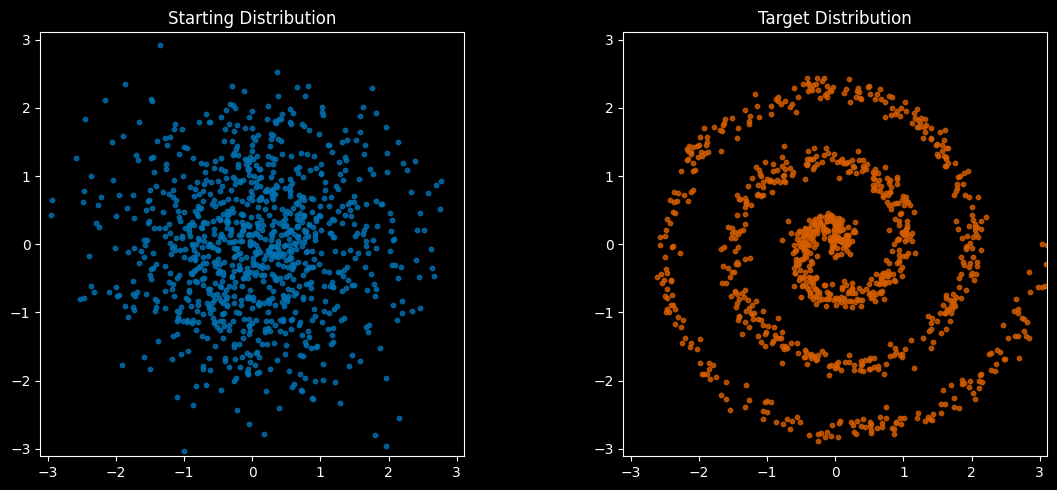

In [5]:
# Create our distributions
n_points = 1000
source, target = create_source_data(n_points), create_target_data(n_points)

# Show the two distributions
plot_distributions(source, target, "Starting Distribution", "Target Distribution")

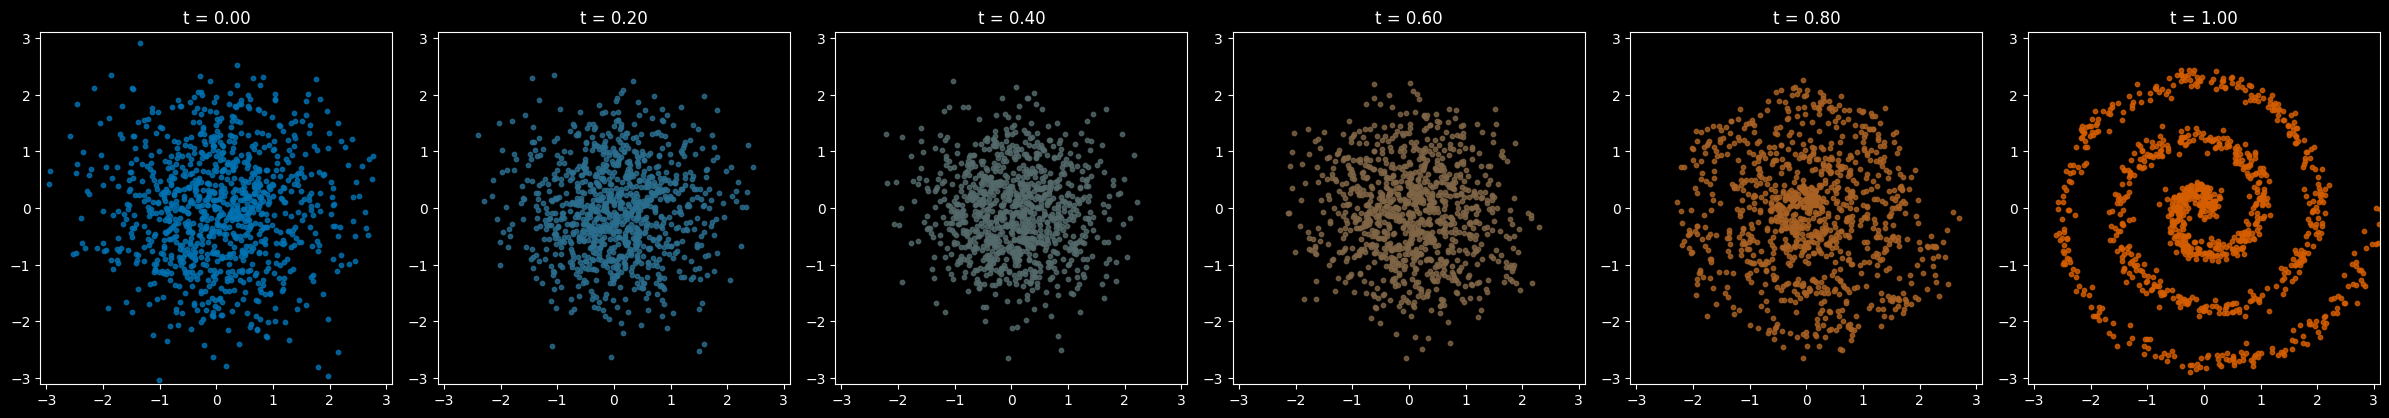

In [6]:
# Show the flow sequence
show_flow_sequence(source, target, n_steps=6)

Note the colors aren't meaningful, they're just added to make it easier to tell what's what.  These are just points in 2-D space.  Here's an animation with no colors, showing the points moving. ...

## What's a Flow? 
In the real world, things typically follow curved paths - like water flowing in a river, or crowds of people navigating around obstacles.  Here's map of wind provided from the WW2010 atmospheric science project at UIUC: at every point in space, the wind has a velocity vector, and the air moves along "streamlines" or "trajectories" parallel to the velocity vectors...

<center>
<img src="http://ww2010.atmos.uiuc.edu/guides/maps/fcst/gifs/3wndhght.gif" alt="atmospheric wind flow pic"><br>
<i>Source: <a href="http://ww2010.atmos.uiuc.edu/%28Gh%29/guides/maps/fcst/3wndhght.rxml">atmos.uiuc.edu</a></i></center><br>

Notice that the streamlines never cross.  If the streams were to cross... "it would be bad." That would imply that the velocity at some point is undefined.

<center>
 <img class="animated-gif" src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExOWVweHVkdncxMmdnOWpidm43bDk3bm9qejh1Z3JyMW1pZzl1NjB0biZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/3o72FiKtrMAjIb0Rhu/giphy.gif" 
     alt="don't cross the sctreams - ghostbusters">

So at every point in space there's a velocity vector telling the little bits of water where to go. And just like water or wind flows may depend not only on spatial position but also time, so too can our velocity vector field depend on position and time. 

Flow matching learns these natural paths by focusing on the *velocity* at each point - essentially asking "which way should each point be moving at this moment?"

Let's visualize this idea with vector fields. A vector field is like a map that shows which way things should move at each point in space. Think of it like:
- A weather map showing wind directions
- Water flowing around rocks in a stream
- A crowd of people moving through a busy plaza

# I. Flow Matching - How We Go With the Flow

## "Simulation-Free" 
Now let's see these visualization tools in action! We'll create two different distributions and see how points might flow between them:

So, how do we get the points from the source distribution to fit with the target distribution? 

The simplest way (though not the only way) is to assume points move in straight lines from source to target. Even though our network might learn more complex paths later, this gives us a starting point for training.

## The Key Mechanism
The training setup for flow matching models is as follows:
1. We start by *randomly pairing* points from the source & the target -- yes, really. :rofl:
2. We move the points along straight trajectories, and the speed of each point is constant.

In [7]:
# ### Generating Training Data

# 💡 Here's a key insight: if we know our starting point (from source distribution) and ending point (from target distribution), 
# we can figure out what the velocity should be at any time t along the path.

# The simplest way (though not the only way) is to assume points move in straight lines from source to target. Even though 
# our network might learn more complex paths later, this gives us a starting point for training.


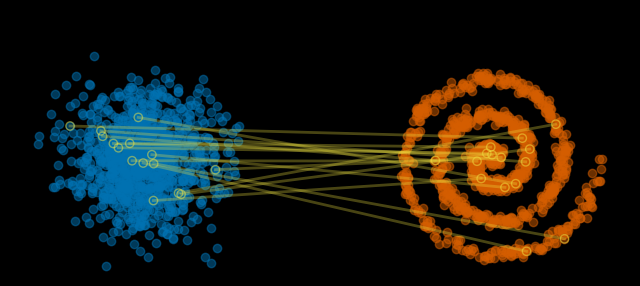

In [8]:
# (Collapsed) Code for 2D flow-matching diagram with crossing lines
source_L = source.clone()
shift = 5
source_L[:,0] -= shift
target_R = target.clone()
target_R[:,0] += shift  # Note: fixed the indexing here from [:0] to [:,0]

fig, ax = plt.subplots(figsize=(8,4))
# show the whole distribution
ax.scatter(source_L[:,0], source_L[:,1], color=source_color, alpha=0.5)
ax.scatter(target_R[:,0], target_R[:,1], color=target_color, alpha=0.5)

# Draw lines connecting points, with source & target points outlined
n_lines = 15
ax.scatter(source_L[:n_lines,0], source_L[:n_lines,1], color=source_color, alpha=0.5, 
           facecolor='none', edgecolor=line_color,)
ax.scatter(target_R[:n_lines,0], target_R[:n_lines,1], color=target_color, alpha=0.5,
           facecolor='none', edgecolor=line_color,)
for i in range(n_lines):
    ax.plot([source_L[i,0], target_R[i,0]], 
        [source_L[i,1], target_R[i,1]], 
        '-', alpha=0.3, color=line_color+[.9], 
        linewidth=2)  # or lw=2

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
for [x, label] in zip([-shift,shift], ['Source','Target']):
    ax.text(x, 4, label, fontsize=12, color='black', ha='center',  va='center',)
plt.show()
plt.close()

Or, if you like, we can view the time coordinate as a third dimension...

In [9]:
# Doin' it to you in 3D. So groovy that I dig me. --George Clinton
# code for 3d plot with crossing lines 
import plotly
import plotly.io as pio
import os
from IPython.display import IFrame, display


def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    pio.renderers.default = 'colab'
else:
    pio.renderers.default = None




def interpolate_color(t,alpha=0.95):
    # Interpolate between source_color and target_color
    rgb = [(1-t) * source_color[i] + t * target_color[i] for i in range(3)]
    # Convert to plotly's RGBA string format
    return f'rgba({int(rgb[0]*255)},{int(rgb[1]*255)},{int(rgb[2]*255)},{alpha})'

def to_rgb_string(color, alpha=.9):
    return f'rgba({int(color[0]*255)},{int(color[1]*255)},{int(color[2]*255)},{alpha})'

n_intermediate = 4
ts = torch.linspace(0, 1, 2 + n_intermediate)
fig = go.Figure()

plotly_source_color = to_rgb_string(source_color)
plotly_target_color = to_rgb_string(target_color)
plotly_line_color = to_rgb_string(line_color,alpha=0.2)

# Add all distributions in ascending order so target (t=1) is drawn last
for i, t in enumerate(ts):
    interp_dist = t*target + (1-t)*source
    
    # For the points we're showing trajectories for, make them transparent
    colors = []
    for j in range(len(interp_dist)):
        if j < n_lines:
            colors.append('rgba(0,0,0,0)')  # transparent
        else:
            colors.append(interpolate_color(t))
            
    # Add main distribution points
    fig.add_trace(go.Scatter3d(
        x=interp_dist[:,0],
        y=interp_dist[:,1],
        z=np.full_like(interp_dist[:,0], t.item()),
        mode='markers',
        marker=dict(size=4, color=colors, opacity=0.5),
        name=f't={t.item():.2f}',
        showlegend=True, 
    ))
    
    # Add hollow circles for trajectory points at this t
    fig.add_trace(go.Scatter3d(
        x=interp_dist[:n_lines,0],
        y=interp_dist[:n_lines,1],
        z=np.full_like(interp_dist[:n_lines,0], t.item()),
        mode='markers',
        marker=dict(
            size=4,
            color='rgba(0,0,0,0)',  # Transparent fill
            line=dict(color=plotly_line_color, width=2),  
            opacity=0.2, 
            symbol='circle'
        ),
        showlegend=False
    ))
    
    # Add second set of slightly different hollow circles
    fig.add_trace(go.Scatter3d(
        x=interp_dist[:n_lines,0],
        y=interp_dist[:n_lines,1],
        z=np.full_like(interp_dist[:n_lines,0], t.item()),
        mode='markers',
        marker=dict(
            size=3,
            color='rgba(0,0,0,0)',  # Transparent fill
            line=dict(color=plotly_line_color, width=2),  # Black border
            opacity=0.3,  # Add this back
            symbol='circle'
        ),
        showlegend=False
    ))

# Add lines connecting subset of points
for i in range(n_lines):
    line_points = torch.stack([(t*target[i] + (1-t)*source[i]) for t in ts])
    
    # Add black connecting lines
    fig.add_trace(go.Scatter3d(
        x=line_points[:,0],
        y=line_points[:,1],
        z=ts,
        mode='lines',
        line=dict(color=plotly_line_color, width=3),
        opacity=0.2,  # Add this back
        showlegend=False
    ))

# Add "Source" and "Target" labels at fixed positions
fig.add_trace(go.Scatter3d(
    x=[-2],
    y=[3],
    z=[0],
    mode='text',
    text=['Source'],
    textposition='middle center',
    textfont=dict(size=16),
    showlegend=False
))

fig.add_trace(go.Scatter3d(
    x=[-2],
    y=[3],
    z=[1],
    mode='text',
    text=['Target'],
    textposition='middle center',
    textfont=dict(size=16),
    showlegend=False
))


fig.add_trace(go.Scatter3d( # dummy data to force ranges
    name="",
    visible=True,
    showlegend=False,
    opacity=0,
    hoverinfo='none',
    x=[-4,4],
    y=[-4,4],
    z=[0,1]
))

fig.update_layout(
    showlegend=False,
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='t',
        bgcolor='black',
        xaxis=dict(gridcolor='gray', showbackground=False),
        yaxis=dict(gridcolor='gray', showbackground=False),
        zaxis=dict(gridcolor='gray', showbackground=False),
    ),
    paper_bgcolor='black',
    width=600,
    height=400,
    margin=dict(l=0, r=0, t=0, b=0),
    font=dict(color='white'),
)



def export_and_embed_plotly(fig, filename, width="100%", height=500):
    """
    Export a Plotly figure to an HTML file and create an iframe to display it
    Parameters:
    - fig: plotly.graph_objects.Figure    The Plotly figure to export
    - filename: str  Path where the HTML file should be saved (e.g., 'assets/my_plot.html')
    - width: int   Width of the iframe in pixels, or a string
    - height: int  Height of the iframe in pixels
    """
    # Create assets directory if it doesn't exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)
        
    pio.write_html(fig, file=filename, include_plotlyjs=True, full_html=True)
    
    return display(IFrame(src=filename, width=width, height=height))
    

# figure has been made
if pio.renderers.default == 'colab':
    fig.show()  # don't show it, rather embed it as an iframe to keep this notebook file size small
else:
    export_and_embed_plotly(fig,'assets/plotly_3dscatter.html') 


There are big issues with doing this: The random pairing results in lots of trajectories that cross each other. But this is a *starting point* Flow Matching.  So in other words, when training a Flow Matching model...



<center>
 <img class="animated-gif" 
src="https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWl4anh6ZnI2NXI1azN1b2dvbjRwMDJodzVqajF0aWwyb2NwYzkxayZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/3o72EWUgbRNfLegO1W/giphy.webp"></center>
 

...welllll ok quite: we're going to allow the *trajectories of individual points* to cross as we train the model. This *is* a bit "confusing" for the model, which will be trying to learn a velocity field, and that isn't defined where trajectories cross. Eventually, however, the model will learn to estimate the *aggregated motion* of many particles, which will sort of average out to arrive at the "bulk motion" of the flow. This is similar to how the brownian motion of many air or water particles averages out on the macroscopic level, giving us streamlines that don't cross.

### The Flow Matching Paradox

As we've noted, there's something subtle and potentially problematic in our approach:

1. A proper flow field should have exactly one velocity vector at each point in space
2. Our training process generates data by naively pairing points and creating straight-line paths
3. These paths frequently cross, which as you note, is physically impossible for a true flow field
4. Yet somehow, this process can still work (when we do it right!)

The resolution to this paradox lies in what the model learns:
- Instead of learning any specific point-to-point mappings
- It learns a "consensus" velocity field that captures the aggregate behavior
- This field represents the most probable flow direction at each point
- The actual learned field won't exactly follow our training trajectories

Think of it like learning traffic patterns:
- Individual cars might take different routes between A and B
- Some routes might cross
- But the learned "flow" represents the dominant direction of motion at each point
- This aggregate flow field can still transform the distribution correctly

This is why flow matching is about transforming *distributions*, not individual points. The learned velocity field might not exactly match any of our training trajectories, but it captures the statistical flow needed to transform one distribution into another.

Here's a visualization from the code we'll execute later in the lesson. We'll plot...

1. Our naive training trajectories (with crossings)
2. The actual learned flow field
3. The paths points take when following the learned field

![a picture of paths crossing but then resolving into curvy yellow lines](assets/cross_uncross_plot.png)

Notice the differences:
1. Left: Training data uses simple straight lines (with many crossings)
2. Middle: The learned flow field is smooth and continuous
3. Right: Actual paths following the flow field are more natural

The model has learned a "compromise" flow field that:
- Maintains one velocity per location
- Captures the overall transformation we want
- May not follow any individual training trajectory exactly

And here (optionally) is an animation:

In [10]:
# Uncomment the next line to generate the animation yourself  (it makes the notebook file too big to include by default)
#display(create_flow_animation(source, target))

( **WARNING: That was all "fake"!** No *actual* models have been trained yet.  ) 

What you're seeing above is just a simple linear interpolation - each point is taking the straightest possible path from its start position to its end position. But real distributions don't usually transform this way! In nature and in many real-world processes, points often follow curved paths or more complex trajectories.

That's where flow models come in. Instead of just moving points in straight lines, they learn the actual paths or "flows" that points should follow to transform one distribution into another. This is especially useful when we're dealing with complex data like images, where we want smooth, natural transformations.

### How is all this different from diffusion models?
If you're familiar with diffusion models (which we covered in an earlier tutorial), you might be wondering how this is different. Here's the key distinction:

- Diffusion models gradually add random noise to data, then learn to reverse that process
- Flow models learn direct transformations between distributions without adding randomness
- Diffusion is like slowly dissolving an image in acid and learning to un-dissolve it
- Flows are like learning the exact choreography of how every point should move

In the next section, we'll start building our own flow model, piece by piece. But first - any questions about the basic concept?

### The Big Idea
The key insight of flow matching is:

> Instead of learning to directly transform point A into point B, we learn the *velocity* each point should have at each moment. These velocities form a vector field that guides points along their paths. Following these velocities moves points from the source to target distribution.

Think of it like teaching someone to ride a bike. Instead of saying "be at point B in 5 minutes", we give them continuous guidance: "lean right a bit here", "pedal harder there", etc. The vector field is like these continuous instructions for how to move.


This is just a simple example of a vector field - it naively points directly from source to target positions. In practice, we'll train a neural network to learn much smoother and more natural vector fields.

Next, we'll implement the actual flow matching mechanism and train it to learn these vector fields. The cool part is that once we have a good vector field, we can start from *any* point and follow the flow to reach our target distribution!

### An Important Question

Before we continue, let's address a crucial question that helps understand what flow matching is really doing:

**Q: Is the model learning to transform the points themselves (e.g. points in A to points in B), or to transform the *probability distribution* of the points in A to the probability distribution of points in B?**

The model is learning to transform the probability distributions, not specific point-to-point mappings. This is a key distinction! Rather than learning "point x₁ should move to point y₁", it's learning "what movement would make the shape of distribution A gradually morph into the shape of distribution B?"

Think of it like this: If you have a cloud of smoke in the shape of a square and want it to form the shape of a circle, you don't need to track each smoke particle's destination - you just need to know how the overall shape should flow to achieve the desired form.  (Still, while training, we do track individual particles). 

In fact, this is one of the main advantages of flow matching: it learns a smooth, continuous transformation of the entire probability space. The vector field tells us:
- An approximate estimate for ANY point in space (not just points in our training data)
- At ANY time during the transformation (from t=0 to t=1)
- Which direction that point should move

One possible analogy: Think of it like learning the rules of a river's flow rather than tracking individual water molecules.

## Learning the Flow: How Does it Actually Work?

Now that we understand we're transforming probability distributions, let's see how flow matching actually learns to do this. The key idea breaks down into three parts:

> For any point in space and any time t between 0 and 1, we want to learn the correct *velocity* (direction and speed) that point should move. These velocities should gradually transform our starting distribution into our target distribution

It's like learning a "wind map" that will blow the starting distribution cloud into the shape of the target distribution cloud. 

Since neural networks are such useful engines for approximation and interpolation, we'll let a neural network "learn" to estimate the mapping between locations and times (as inputs), and velocities (as outputs). 


### The Neural Network (just spits out velocities)
Below is the entire neural network!  Looks pretty simple, right?  Its only job is, given a position in space and a time, to output a velocity vector.  *That's all it does.*  It is only a model for calculating velocity vectors. 

The entire rest of the system then uses these generated velocities to move points from place to place. 

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class VelocityNet(nn.Module):
    def __init__(self, input_dim, h_dim=128):
        super().__init__()
        self.fc_in  = nn.Linear(input_dim + 1, h_dim)
        self.fc2    = nn.Linear(h_dim, h_dim)
        self.fc3    = nn.Linear(h_dim, h_dim)
        self.fc_out = nn.Linear(h_dim, input_dim)
    
    def forward(self, x, t, act=F.gelu):
        t = t.expand(x.size(0), 1)  # Ensure t has the correct dimensions
        x = torch.cat([x, t], dim=1)
        x = act(self.fc_in(x))
        x = act(self.fc2(x))
        x = act(self.fc3(x))
        return self.fc_out(x)

# Instantiate the model
input_dim = 2
model = VelocityNet(input_dim)

In [12]:
# Integrator code: generate/predict samples using the trained model
@torch.no_grad()
def integrate_euler(model, initial_points, n_steps=100, 
                     save_trajectories=False, warp_fn=None, jitter=0):
    """this 'sampling' routine is primarily used for visualization."""
    current_points = initial_points.clone()
    dt = 1.0 / n_steps
    dtw = dt
    if save_trajectories: trajectories = [current_points.cpu().clone()]

    with torch.no_grad():
        ones = torch.ones(current_points.size(0), 1)
        for i in range(n_steps):
            t = ones * (i * dt)
            if warp_fn is not None: # don't worry about this for now. we'll get to it later
                t, dtw = warp_fn(t, dt=dt)
            velocity = model(current_points, t)
            current_points = current_points + velocity * dtw # forward Euler
            if jitter>0: current_points = current_points + jitter*torch.randn_like(current_points) # for making it like a diffusion model ;-) 

            if save_trajectories: trajectories.append(current_points.cpu().clone())
    
    return current_points if not save_trajectories else current_points, torch.stack(trajectories)

generate_samples = integrate_euler # just lil' alias for the probability / diffusion model crowd ;-) 

Testing visualization routines (before training):


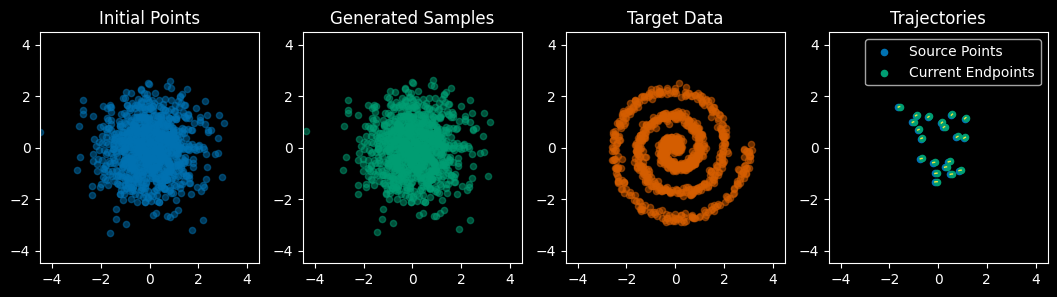

In [13]:
# Viz code: calls integrator to calc motion given v field, makes pictures
def viz(val_points, target_samples, trained_model, size=20, alpha=0.5, integrator=integrate_euler):
    # Generate and visualize new samples
    generated_samples, trajectories = integrator(trained_model, val_points, save_trajectories=True)

    n_viz = min(20, len(trajectories[0]))  # Number of trajectories to visualize
    
    fig, ax = plt.subplots(1,4, figsize=(13,3))
    data_list = [val_points, generated_samples, target_samples] 
    label_list = ['Initial Points', 'Generated Samples', 'Target Data','Trajectories']
    color_list = [source_color, pred_color, target_color]
    global_max = max( torch.max(torch.abs(torch.cat(data_list)),0)[0][0],  torch.max(torch.abs(torch.cat(data_list)),0)[0][1] )
    for i in range(len(label_list)):
        ax[i].set_title(label_list[i]) 
        ax[i].set_xlim([-global_max, global_max]) 
        ax[i].set_ylim([-global_max, global_max])
        if i < 3: # non-trajectory plots
            ax[i].scatter( data_list[i][:, 0], data_list[i][:, 1], s=size, alpha=alpha, 
                          label=label_list[i], color=color_list[i])
        else:
            # Plot trajectory paths first
            for j in range(n_viz):
                path = trajectories[:, j]
                ax[3].plot(path[:, 0], path[:, 1], '-', color=line_color, alpha=1, linewidth=1)
            
            # Then plot start and end points for the SAME trajectories
            start_points = trajectories[0, :n_viz]
            end_points = trajectories[-1, :n_viz]  
            ax[3].scatter(start_points[:, 0], start_points[:, 1], color=source_color, s=size, alpha=1, label='Source Points')
            ax[3].scatter(end_points[:, 0], end_points[:, 1], color=pred_color, s=size, alpha=1, label='Current Endpoints')
            ax[3].legend()

    plt.show()
    plt.close()

# Visualize the data
n_samples = 1000
source_samples = create_source_data(n_samples)
target_samples = create_target_data(n_samples)
val_points = create_source_data(n_samples)
print("Testing visualization routines (before training):") 
viz(val_points, target_samples,  model) 

## Training Code
The goal of the training code is twofold: 
1. to expose the model as many locations and times as possible -- at least for those times & locations that "matter most". This exposure is what I'll refer to as "coverage".
2. to force it to learn to generate (approximately) correct velocities at those times and locations.

That's it.  The training code doesn't actually do any integration or solving, but we'll typically execute the integration just to visualize "how we're doing" as the training progresses. 

The clever part about flow matching is how we train this network. For each training step:

1. Sample random points from our source distribution
2. Sample random time points between 0 and 1
3. Calculate where these points *should* be at those times (we'll see how in a moment)
4. Calculate what velocity they *should* have at those times
5. Train the network to predict these velocities

Let's implement this step by step...

In [14]:
# Code for train_model() training loop
import torch.optim as optim

def train_model(model, n_epochs=100, lr=0.003, batch_size=2048, status_every=1, viz_every=1, warp_fn=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    step, n_steps = 0, 100
    
    for epoch in range(n_epochs):
        model.train()
        pbar = tqdm(range(n_steps), leave=False)
        for _ in pbar:
            step += 1
            optimizer.zero_grad()
    
            # by randomly generating new data each step, we prevent the model from merely memorizing
            source_samples = create_source_data(batch_size)
            target_samples = create_target_data(batch_size)
            
            t = torch.rand(source_samples.size(0), 1)
            if warp_fn: t = warp_fn(t)    # time warp is good for coverage but not as helpful for training as it is during integration/sampling
            interpolated_samples = source_samples * (1 - t) + target_samples * t
            line_directions = target_samples - source_samples
            
            drift = model(interpolated_samples, t)
            loss = loss_fn(drift, line_directions)
            
            loss.backward()
            optimizer.step()

            status_str = f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}'
            pbar.set_description(status_str)
        
        if (epoch + 1) % viz_every == 0:
            model.eval()
            clear_output(wait=True)  # Clear previous plots
            viz(val_points, target_samples[:val_points.shape[0]], model)
            plt.show()
            plt.close()  # Close the figure to free memory
            model.train()
            
        if epoch==n_epochs-1: print(status_str)  # keep last status from being cleared
    
    return model

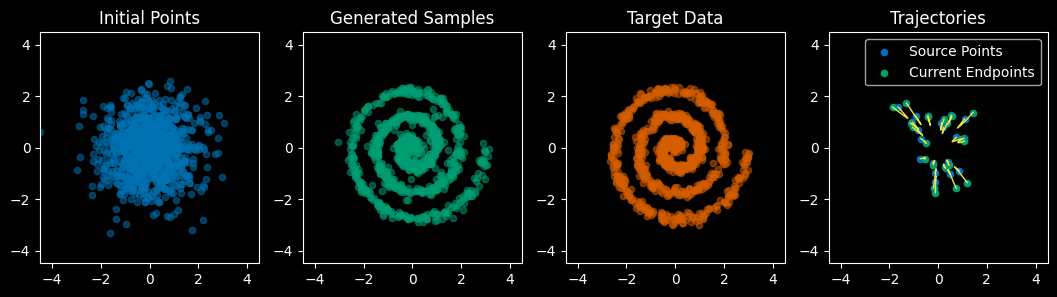

Epoch [100/100], Loss: 1.7751


In [15]:
trained_model = train_model(model, n_epochs=100) # this will take about 10 minutes on a GPU.

Here's an animation of our model integrating the flow from start to finish:

In [16]:
# Code for animating points in flow
import matplotlib.animation as animation
from IPython.display import HTML, display, clear_output
from matplotlib import rc
import os

@torch.no_grad()
def create_flow_animation(start_dist, models, titles=None, figsize=None, n_frames=50,
                         integrator=integrate_euler, jitter=0, save_file=None, height=4):
    """
    Create an animation showing multiple distribution flows
    
    Args:
        start_dist: Starting distribution
        models: List of models to animate
        titles: List of titles for each subplot (optional)
        figsize: Figure size (optional)
        n_frames: Number of animation frames
        integrator: Integration function to use
        jitter: Amount of jitter to add
        save_file: Path to save animation (optional)
        height: Height of each subplot
    """
    plt.close('all')  # Close all open figures
    
    # Handle input validation
    if not isinstance(models, list):
        models = [models]
    
    n_plots = len(models)
    
    if titles is None:
        titles = [f'Flow {i+1}' for i in range(n_plots)]
    elif len(titles) != n_plots:
        raise ValueError(f"Number of titles ({len(titles)}) must match number of models ({n_plots})")
    
    # Calculate figure size
    if figsize is None:
        figsize = [height * n_plots, height]
    
    # Create subplots
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    plt.close()  # Close the figure immediately
    
    # Initialize scatters and trajectories
    scatters = []
    all_trajectories = []
    
    # Generate trajectories for each model
    max_range = abs(start_dist).max().item()
    
    for i, model in enumerate(models):
        end_dist, trajectories = integrator(model, start_dist.clone(), n_steps=n_frames, 
                                          save_trajectories=True, jitter=jitter)
        all_trajectories.append(trajectories)
        scatters.append(axes[i].scatter([], [], alpha=0.6, s=10, color=wong_pink))
        
        # Update max range
        max_range = max(max_range, abs(end_dist).max().item())
    
    # Set up axes
    for i, ax in enumerate(axes):
        ax.set_xlim((-max_range, max_range))
        ax.set_ylim((-max_range, max_range))
        ax.set_aspect('equal')
        ax.set_xticks([])
        for spine in ['top', 'right', 'bottom', 'left']:
            ax.spines[spine].set_visible(False)
        ax.set_title(titles[i])
    
    def init():
        """Initialize animation"""
        for scatter in scatters:
            scatter.set_offsets(np.c_[[], []])
        return tuple(scatters)
    
    def animate(frame):
        """Update animation frame"""
        # Update axis limits (in case they need to be adjusted)
        for ax in axes:
            ax.set_xlim((-max_range, max_range))
            ax.set_ylim((-max_range, max_range))
        
        # Update scatter positions
        for scatter, trajectories in zip(scatters, all_trajectories):
            scatter.set_offsets(trajectories[frame].numpy())
        
        return tuple(scatters)
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=n_frames, interval=20, blit=True)
    
    # Handle saving or displaying
    if save_file:
        os.makedirs(os.path.dirname(save_file), exist_ok=True)
        anim.save(save_file, writer='ffmpeg', fps=30)
    else:
        rc('animation', html='jshtml')
        return HTML(anim.to_jshtml())
    plt.close()

In [50]:
anim_file = 'assets/particles_fm.mp4'
create_flow_animation(val_points.clone(), models=[trained_model], titles=['Flow Matching'],
                      n_frames=50, save_file=anim_file)
HTML(f"""<center><video height="350" controls loop><source src="{anim_file}" type="video/mp4">
  Your browser does not support the video tag.
   </video></center>""")

So, even though we trained using trajectories that crossed, what the model learned were non-crossing (but curvy!) trajectories. Here's a static plot of these:

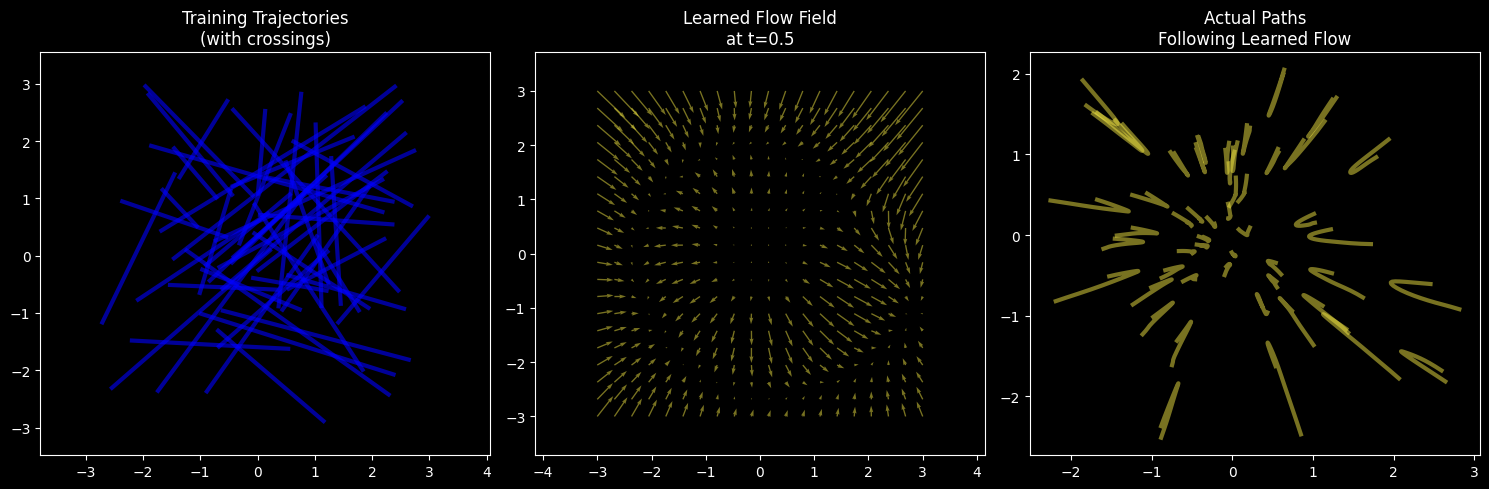

In [18]:
@torch.no_grad()
def plot_training_trajectories_vs_learned_flow(model):
   """Compare training trajectories with learned flow field"""
   plt.figure(figsize=(15, 5))
   
   # 1. Plot some training trajectories
   plt.subplot(131)
   n_trajs = 50  # Number of trajectories to show
   source = create_gaussian_data(n_trajs)
   target = create_square_data(n_trajs)
   current_points = source.clone()

   
   # Plot straight-line trajectories from source to target
   times = torch.linspace(0, 1, 20)
   for i in range(n_trajs):
       traj = source[i:i+1] * (1 - times.reshape(-1, 1)) + target[i:i+1] * times.reshape(-1, 1)
       plt.plot(traj[:, 0], traj[:, 1], 'b-', alpha=0.6, linewidth=3)
   plt.title('Training Trajectories\n(with crossings)')
   plt.axis('equal')
   
   # 2. Plot learned flow field
   plt.subplot(132)
   x = torch.linspace(-3, 3, 20)
   y = torch.linspace(-3, 3, 20)
   X, Y = torch.meshgrid(x, y, indexing='ij')
   points = torch.stack([X.flatten(), Y.flatten()], dim=1)
   
   # with torch.no_grad():
   #     t =  0.5  # Show flow field at t=0.5
   #     ones = torch.ones(points.size(0), 1)

   ones = torch.ones(points.size(0), 1)
   t = ones * (0.5)
   velocities = model(points, t)
   #print("points.shape, ones.shape = ",points.shape, ones.shape) 
   #velocities = model(points, t*ones)
   
   plt.quiver(points[:, 0], points[:, 1], 
             velocities[:, 0], velocities[:, 1],
             alpha=0.5, color=line_color, linewidth=3)
   plt.title('Learned Flow Field\nat t=0.5')
   plt.axis('equal')
   
   # 3. Plot actual paths taken using learned flow
   plt.subplot(133)
   source = create_gaussian_data(n_trajs)
   
   # Use RK4 to follow the learned flow
   paths = []
   n_steps = 20
   dt = 1.0 / n_steps
   
   with torch.no_grad():
       ones = torch.ones(current_points.size(0), 1)
       for i in range(n_steps):
           paths.append(current_points.clone())
           
           # RK4 step
           t = ones * (i * dt)
           k1 = model(current_points, t)
           k2 = model(current_points + k1 * dt/2, t + dt/2)
           k3 = model(current_points + k2 * dt/2, t + dt/2)
           k4 = model(current_points + k3 * dt, t + dt)
           
           current_points = current_points + (k1 + 2*k2 + 2*k3 + k4) * dt/6
   
   paths = torch.stack(paths)
   
   # Plot the actual paths
   for i in range(n_trajs):
       traj = paths[:, i, :]
       plt.plot(traj[:, 0], traj[:, 1], color=line_color, alpha=0.5, linewidth=3)
   plt.title('Actual Paths\nFollowing Learned Flow')
   plt.axis('equal')
   
   plt.tight_layout()
   plt.savefig('assets/cross_uncross_plot.png')
   plt.show()
   plt.close()

# Run the visualization
plot_training_trajectories_vs_learned_flow(trained_model)

...So we see that even though the model was trained using lots of crossing paths, it learned a smooth flow from them! 

# II. Rectified Flow, via "Reflow"

We're now going to discuss Rectified Flow, which is made possible via a idea called "ReFlow".  Before we do that, though, we should make a couple improvements to how we use the model we just trained. 

## Improvements
Both of these don't necessarily require to retraining the model, yet they help to make efficient, accurate use of it.

1. More accurate integrator: Euler $\rightarrow$ RK4
2. Better resolution where needed: Time Warping

### Improvement #1: Better Integration / Sampling 

The prevelent use of "forward Euler" integration in the ML community someties comes as a bit of a mystery to simulation-oriented physicists and applied mathematicians. Forward Euler is really inaccurate and can lead to instabilities, but it has the advantages that

1. It's easy to implement
2. It's fast
3. It doesn't require extra storage

And the fact that it's pretty inaccurate may not be seen much of an issue when everything's an approximation anyway, and the ODEs we integrate typically aren't "stiff," and maybe we're only using it to generate images of dogs and cats, etc.  But... I'm here to say IT MAKES A DIFFERENCE. 

People who work with diffusion models know this, and one typically finds a host of integration options, e.g. in [Katherine Crowson's k-diffusion package](https://github.com/crowsonkb/k-diffusion).  For here we'll just implement the popular 4th-order Runge-Kutta (RK4) scheme, which predictor-corrector method so it's more expensive in that each step requires 4 function evaluations instead of forward Euler's 1 step, but the advantages you gain in accuracy are seriously worth it (e.g., because you can take much longer steps in time). 

In [19]:
# Collapsed: Code to Integrate motion with 4th-order Runge-Kutta scheme.
def rk4_step(f, # function that takes (t,y) and returns dy/dt, i.e. velocity
             t, # current t value
             y, # current location
             h, # requested step size (in time) 
             ):
    k1 =  f(y, t)
    k2 =  f(y + h*k1/2, t + h/2) 
    k3 =  f(y + h*k2/2, t + h/2) 
    k4 =  f(y + h*k3, t + h) 
    return y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

@torch.no_grad()
def integrate_rk4(model, initial_points, n_steps=50, 
                     save_trajectories=False, warp_fn=None, jitter=0):
    current_points = initial_points.clone()
    dt = 1.0 / n_steps
    dtw = dt
    if save_trajectories: trajectories = [current_points.cpu().clone()]

    with torch.no_grad():
        ones = torch.ones(current_points.size(0), 1)
        for i in range(n_steps):
            t = ones * (i * dt)
            if warp_fn: t, dtw = warp_fn(t, dt=dt)
            current_points = rk4_step( model , t, current_points, dtw)
            if jitter>0: current_points = current_points + jitter*torch.randn_like(current_points)
            if save_trajectories: trajectories.append(current_points.cpu().clone())
                
    if save_trajectories: 
        return current_points, torch.stack(trajectories)
    return current_points

We could even upgrade to "RKF45" algorithm which adaptively adjusts the integration time step size, however... we'll just keep things simple via a different method that adjusts the time steps, since we can pretty much tell where we need smaller steps: i.e. the curvy parts in the middle of our flow trajectories.

### Improvement #2: More Points Where Needed (via Time Warping)

You'll notice that trajectories are very sharply curved in the middle, but relatively straight at the start and end. Just as you'd slow down when driving around a sharp turn, we need smaller integration steps in these curved regions for accuracy.

This idea of non-uniform temporal sampling appears throughout generative models. Esser et al.'s "FLUX" paper specifically designs their sampling distribution to concentrate points in the middle of the integration where accuracy is most crucial[^1]. The same principle applies here: during training, we need good coverage where the model needs to make careful predictions, and during inference, high-curvature regions require denser sampling.

A handy S-shaped time-warping function is this polynomial that lets us vary the concentration of points:

$$ f(t) =  4(1-s)t^3 + 6(s-1) t^2 + (3-2s)t, \ \ \ \ \ \  t\in[0,1], \ \ \ s\in[0,3/2] $$

The parameter $s$ is the slope at t=1/2, and controls where points concentrate: values between 0 and 1 give us more points in the middle, which is exactly what we want for these curved trajectories. The value $s=0.5$ is a good choice, as we'll see shortly.

<p style="font-size:10px">
(Note: this $f(t)$ is a close approximation to the "mode function" Eq. 20 in <a href="https://arxiv.org/abs/2403.03206">Esser et al</a>, with their $s$ being about (1.75 - $s_{\rm mine}$), and with $t\rightarrow 1-t$.  My blue line is right underneath their purple line in the Desmos graph below -- I didn't plan that, just similar minds at work!  Both our curves can do the Karras et al cosines schedule, the green line below.)</p>

In [60]:
%%html
<center>
<a href="https://www.desmos.com/calculator/g6ffbljlng">Interactive Desmos Graph Link</a><br>
<iframe src="https://www.desmos.com/calculator/hfjxlwycmz?embed" width="250" height="250" style="border: 1px solid #ccc" frameborder=0></iframe>

This approach gives us better accuracy with fewer total integration steps - a win for both precision and computational efficiency.

In [21]:
def warp_time(t, dt=None, s=.5):
    """Parametric Time Warping: s = slope in the middle. 
        s=1 is linear time, s < 1 goes slower near the middle, s>1 goes slower near the ends
        s = 1.5 gets very close to the "cosine schedule", i.e. (1-cos(pi*t))/2, i.e. sin^2(pi/2*x)"""
    if s<0 or s>1.5: raise ValueError(f"s={s} is out of bounds.")
    tw = 4*(1-s)*t**3 + 6*(s-1)*t**2 + (3-2*s)*t 
    if dt:                           # warped time-step requested; use derivative
        return tw,  dt * 12*(1-s)*t**2 + 12*(s-1)*t + (3-2*s) 
    return tw

### Combining the Improvements
The benefits of both the time warping and the higher-order integrator can be illustrated via this study of integrating motion along a parabolic curve:

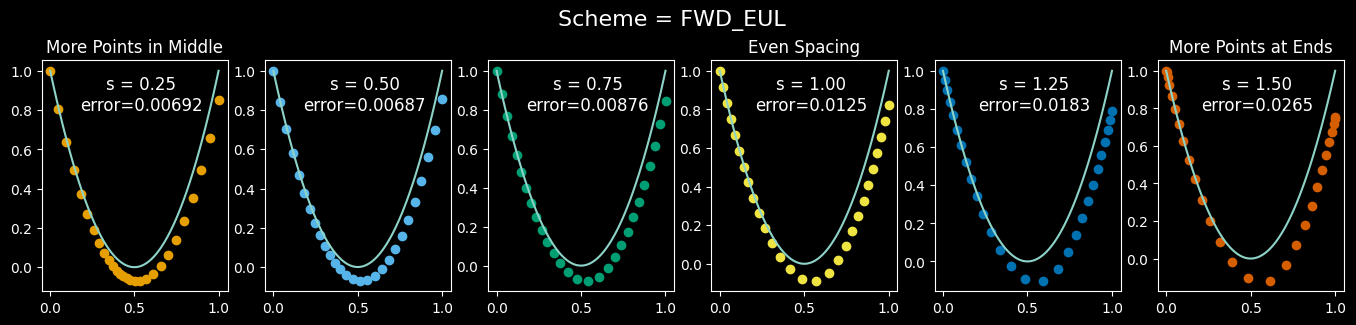

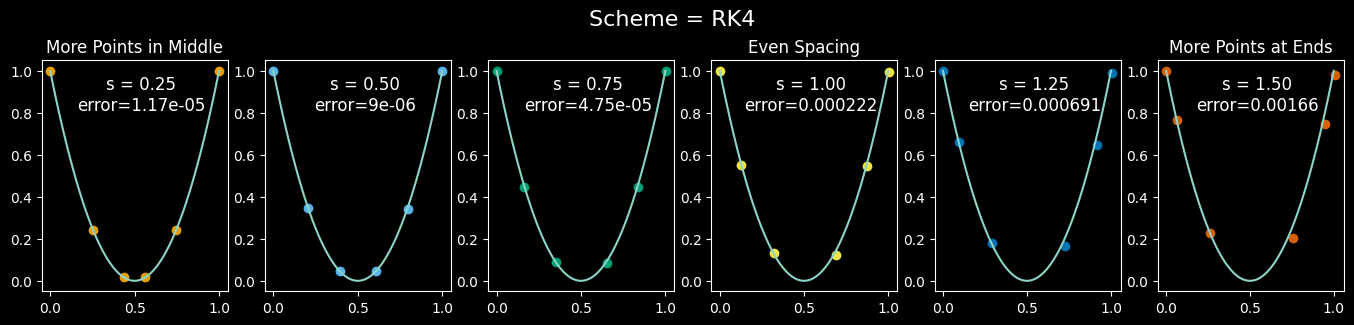

In [22]:
# Collapsed. viz code for parabolic path / variable dot-spacing figure
from functools import partial 

parab   = lambda x: 4*(x-0.5)**2  # curve shape
d_parab = lambda x: 8*(x-0.5)     # derivative
ds      = lambda x: torch.sqrt(1 + d_parab(x)**2)  # differential arc length

def calculate_total_arc_length(n=1000):
    """Calculate the total arc length of the parabola y = 4(x - 0.5)**2 from x=0 to x=1"""
    x_values = torch.linspace(0, 1, n)
    arc_length_values = ds(x_values)
    total_arc_length = torch.trapz(arc_length_values, x_values)
    return total_arc_length

def fake_velocity_model(loc, t, speed=1.0):
    """For demo purposes only: Follow a parabolic path and move at unit speed
    Compute the x and y components of the velocity along the parabola y = 4(x - 0.5)^2"""
    x, y = loc[:, 0], loc[:, 1]    
    slope = d_parab(x)
    direction = torch.stack([torch.ones_like(slope), slope], dim=1)    
    magnitude = torch.norm(direction, dim=1, keepdim=True)
    unit_velocity = direction / magnitude    
    return unit_velocity*speed

@torch.no_grad()
def integrate_motion_along_parabola(model, initial_points, n_steps=100, 
                     scheme='fwd_eul', s=0.5,):
    """one-off integrator used only for this one visualization figure. don't use for anything else"""
    current_points = initial_points.clone()
    trajectories = [current_points.cpu().clone()]
    ts = torch.linspace(0,1.0, n_steps) 
    ts = warp_time(ts, s=s)                       # here's the time worpage
    speed = calculate_total_arc_length()   # Total travel time is 1.0 so speed "=" distance
    scaled_model = partial(model, speed=speed)
    with torch.no_grad():
        for i in range(n_steps-1):
            dt = ts[i+1] - ts[i]
            if scheme=='rk4': 
                current_points = rk4_step( scaled_model , ts[i], current_points.clone(), dt)
            elif scheme=='fwd_eul':
                velocity = scaled_model(current_points, ts[i+1])
                current_points = current_points + velocity * dt  
            else:
                raise ValueError(f"Invalid scheme = {scheme}") 
            trajectories.append(current_points.cpu().clone())
    
    return torch.stack(trajectories)


for scheme_i, scheme in enumerate(['fwd_eul','rk4']):
    plt.close()
    print()
    with torch.no_grad():
        t_curve = torch.linspace(0,1,100)
        n_t_points = [28, 6][scheme_i]
        t_points = torch.linspace(0,1,n_t_points)
        dt = t_points[1] - t_points[0]
        n_s = 6    # number of different s values to show
        fig, ax = plt.subplots(1, n_s, figsize=(n_s*2.8, 3))
        plt.suptitle(f"Scheme = {scheme.upper()}", fontsize=16, y=1.05)
        initial_points = torch.tensor([[0,1]])
        for i, s in enumerate(torch.linspace(.25, 1.5, n_s)):
            ax[i].plot(t_curve, parab(t_curve))    # solid line showing path
            
            traj = integrate_motion_along_parabola(fake_velocity_model, initial_points, n_steps=n_t_points, 
                        s=s, scheme=scheme).squeeze() 
            err_str = f"\nerror={F.mse_loss(parab(traj[:,0]),traj[:,1]):.3g}"
            ax[i].scatter(traj[:,0], traj[:,1], label=f's = {s:.2f}{err_str}', color=(wong_cmap*2)[i])
    
            legend = ax[i].legend(loc='upper center', frameon=False, markerscale=0, handlelength=0, fontsize=12)
            for text in legend.get_texts():
                text.set_ha('center')
    
            if abs(s-1.0) < 1e-6: ax[i].set_title('Even Spacing') 
                
        ax[0].set_title('More Points in Middle')
        ax[-1].set_title('More Points at Ends')
        plt.show()
        plt.close()

It's cool how the bottom row of figures, despite showing less error that the top row, actually involve *less* computational cost in terms of number of function evaluations, though the RK4 scheme needs 4 times the storage compared for forward Euler. (The good news is that no PyTorch gradients need to be stored; the integrator is only ever used when the model is in "eval" mode.)

You might guess that $s=0.5$ is a solid choice, and you'd be right! (You can experiment a bit to verify this.) We'll use $s=0.5$ for what follows.

## Get Rectified: ReFlow

When we train the student model, aka the rectified model, note that the "target data" will no longer be supplied by the true target data anymore.  Rather we will be using the trajectory endpoints integrated/generated using the teacher model, i.e. the pretrained flow model.  

So.... how close of an approximation are those learned flow endpoints to the real thing?   We're going to be approximating an approximation, but how good is the original approximation? 

Let's take a look...

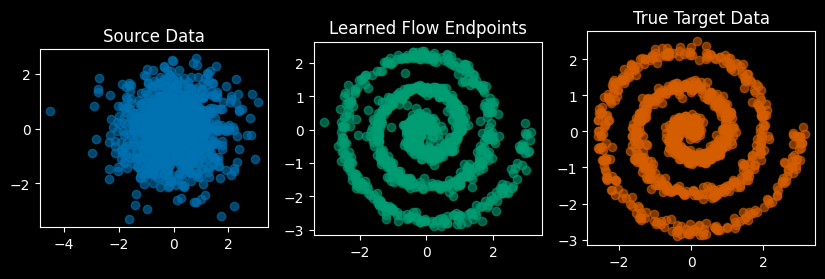

In [23]:
# quick check of how our flow endpoints are looking
pretrained_model = trained_model 
pretrained_model.eval()
reflow_targets = integrate_rk4(pretrained_model, val_points)

fig, ax = plt.subplots(1,3, figsize=(10,3))
for i, [data, color, label] in enumerate(zip([val_points,   reflow_targets, target_samples], 
                                             [source_color, pred_color,     target_color],
                                             ['Source Data', 'Learned Flow Endpoints', 'True Target Data'])):
    ax[i].scatter(data[:,0], data[:,1], color=color, label=label, alpha=0.6)
    ax[i].set_aspect('equal')
    ax[i].set_title(label)
plt.show()
plt.close()

....ok, so we see the learned outputs are a bit different from the true data, but they're not bad.  Let's now train the "reflow" model. 

### Train the Reflowed Model

In [24]:
# Code for the new training loop, feature ReFlowed targets
def train_rectified_model(model, pretrained_model=None, 
                          n_epochs=20, lr=0.001, batch_size=2048, 
                          status_every=1, viz_every=1, # in epochs
                          new_points_every=1, # in steps 
                          warp_fn=warp_time, 
                          integrator=integrate_rk4, # rk4 so we get high-quality outputs while reflowing
                          ):
    """This is almost IDENTICAL to the previous training routine. 
        The difference is the change in "target_samples" via what the RF authors call "ReFlow": 
        Instead of (randomly) paring source points with points in the "true target distribution", 
        we use the pretrained/teacher model to integrate the source points to their (predicted) flow endpoints 
        and use THOSE as the "target" values.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    step, n_steps = 0, 100
    
    for epoch in range(n_epochs):
        model.train()
        pbar = tqdm(range(n_steps), leave=False)
        for _ in pbar:
            step += 1
            optimizer.zero_grad()

            if step % new_points_every == 0:  # you could in theory not draw new points with each step, though we will. 
                source_samples = create_source_data(batch_size)
                # HERE is the ReFlow operation:
                target_samples = integrator(pretrained_model, source_samples) ### <-- THIS IS THE KEY BIT. Previously we used create_target_data(batch_size) 

            t = torch.rand(source_samples.size(0), 1)
            if warp_fn: t = warp_fn(t)  # time warp here (different from use in integrator!) helps focus "coverage" i.e. sampling the space
                
            interpolated_samples = source_samples * (1 - t) + target_samples * t            
            v = model(interpolated_samples, t)
            line_directions = target_samples - source_samples 
            loss = loss_fn(v, line_directions)
            
            loss.backward()
            optimizer.step()
            
            pbar.set_description(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4g}')
        
        if (epoch + 1) % viz_every == 0:
            model.eval()
            clear_output(wait=True)  # Clear previous plots
            viz(val_points, target_samples[:val_points.shape[0]], model)  # don't need rk4 for rect model viz b/c paths r straight
            plt.show()
            plt.close()  # Close the figure to free memory
            model.train()
    
    return model

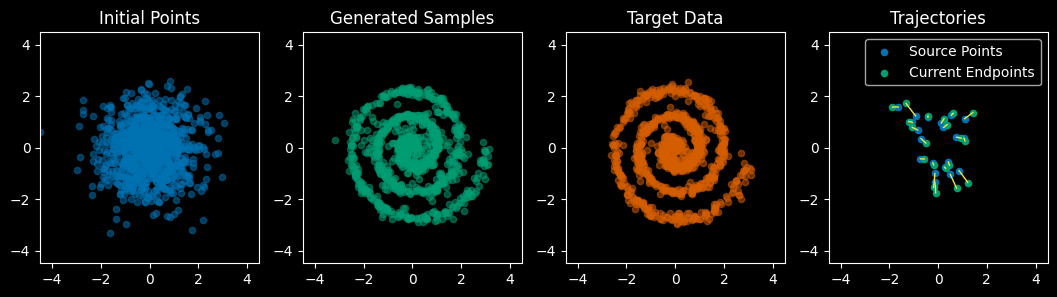

In [25]:
import copy

pretrained_model = trained_model
rectified_model = copy.deepcopy(pretrained_model) # no need to train student from scratch, start from teacher's weights
pretrained_model.eval(), rectified_model.train()

rectified_model = train_rectified_model(rectified_model, pretrained_model)

Oooo, look how straight the trajectories are now!  Let's compare animations of the original flow matching model with the reflowed rectified flow model: 

In [36]:
rect_eval = rectified_model.eval()

anim_file = "assets/particles_fm_vs_rf.mp4"
create_flow_animation(val_points.clone(), models=[pretrained_model, rectified_model], 
        n_frames=50, titles=['Flow Matching','Rectified Flow'], save_file=anim_file)

In [49]:
%%html
<center><video height="350" controls loop><source src="assets/particles_fm_vs_rf.mp4" type="video/mp4">
  Your browser does not support the video tag.</video></center>

In [39]:
# code for create_streamline_animation
@torch.no_grad()
def create_streamline_animation(start_dist, model, model2=None, n_frames=50, show_points=False, titles=None, 
                                integrator=integrate_euler,  # euler's ok for reflow'd rect model
                                save_file=None, 
                               ):
    """Create an animation showing distribution flow with streamplot background"""
    figsize = [5,5]
    if titles is None: 
        titles = ['Flow Matching']
        if model2: titles += ['Rectified Flow']
    if model2: 
        figsize[0] *= 2
    n_plots = 1 + (model2 is not None)
    fig, ax = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots==1: ax = [ax]
    plt.close()

    end_dist, trajectories = integrator(model, start_dist.clone(), n_steps=n_frames, save_trajectories=True)
    scatter = ax[0].scatter([], [], alpha=0.6, s=10, color=wong_pink, zorder=1)
    if model2: 
        _, trajectories2 = integrator(model, start_dist.clone(), n_steps=n_frames, save_trajectories=True)
        scatter2 = ax[1].scatter([], [], alpha=0.6, s=10, color=wong_pink, zorder=1)
        
    max_range = max( abs(start_dist).max().item(), abs(end_dist).max().item() )
    
    for i in range(len(ax)):
        ax[i].set_xlim((-max_range, max_range))
        ax[i].set_ylim((-max_range, max_range))
        ax[i].set_aspect('equal')
        if titles: ax[i].set_title(titles[i])


    # Create grid for streamplot
    grid_dim = 50
    x = np.linspace(-max_range, max_range, grid_dim)
    y = np.linspace(-max_range, max_range, grid_dim)
    X, Y = np.meshgrid(x, y)

    # Convert grid to torch tensor for model input
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    color = wong_pink if show_points else (0,0,0,0) 

    dt = 1.0 / n_frames 
    
    def init():
        for i in range(len(ax)):
            ax[i].clear()
            ax[i].set_xlim((-max_range, max_range))
            ax[i].set_ylim((-max_range, max_range))
        scatter.set_offsets(np.c_[[], []])
        if model2:
                scatter.set_offsets(np.c_[[], []])
                return (scatter,scatter2)
        return (scatter,)
    
    def animate(frame):
        for i in range(len(ax)):
            ax[i].clear()
            ax[i].set_xlim((-max_range, max_range))
            ax[i].set_ylim((-max_range, max_range))
            if titles: ax[i].set_title(titles[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            for spine in ['top','right','bottom','left']:
                ax[i].spines[spine].set_visible(False)

        # Update scatter plot
        current = trajectories[frame]
        scatter = ax[0].scatter(current[:, 0], current[:, 1], alpha=0.6, s=10, color=color, zorder=1)
        if model2:
            current2 = trajectories2[frame]
            scatter2 = ax[i].scatter(current2[:, 0], current2[:, 1], alpha=0.6, s=10, color=color, zorder=1)

        # Calculate vector field for current time
        t = torch.ones(grid_points.size(0), 1) * (frame * dt)
        t = warp_time(t)
        velocities = model(grid_points, t)
        U = velocities[:, 0].reshape(X.shape)
        V = velocities[:, 1].reshape(X.shape)

        x_points = np.linspace(-max_range, max_range, 15)
        y_points = np.linspace(-max_range, max_range, 15)
        X_arrows, Y_arrows = np.meshgrid(x_points, y_points)
        start_points = np.column_stack((X_arrows.ravel(), Y_arrows.ravel()))
        ax[0].streamplot(X, Y, U.numpy(), V.numpy(),
             density=5,  # Controls line spacing
             color=line_color, # (0, 0, 1, 0.7),
             linewidth=0.8, maxlength=0.12,
             start_points=start_points,  # This should give more arrows along paths
             arrowsize=1.2,
             arrowstyle='->')  
        
        if model2: 
            velocities2 = model2(grid_points, t)
            U2 = velocities2[:, 0].reshape(X.shape)
            V2 = velocities2[:, 1].reshape(X.shape)
            start_points2 = np.column_stack((X_arrows.ravel(), Y_arrows.ravel()))
            ax[1].streamplot(X, Y, U2.numpy(), V2.numpy(),
                 density=5,  # Controls line spacing
                 color=line_color, # (0, 0, 1, 0.7),
                 linewidth=0.8, maxlength=0.12,
                 start_points=start_points2,  # This should give more arrows along paths
                 arrowsize=1.2,
                 arrowstyle='->') 


        # Update particle positions
        t = torch.ones(current.size(0), 1) * (frame * dt)
        t, dtw = warp_time(t, dt=dt)
        velocity = model(current, t)
        current = current + velocity * dtw
        if model2: 
            velocity2 = model2(current2, t)
            current2 = current2 + velocity2 * dtw
            return (scatter, scatter2,)
        return (scatter,)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=n_frames, interval=20, blit=False)

    if save_file:
        anim.save(save_file, writer='ffmpeg', fps=30)
    
    rc('animation', html='jshtml')
    return HTML(anim.to_jshtml())

In [42]:
# uncomment the next line to generate your own animation
#create_streamline_animation(val_points, pretrained_model, model2=rectified_model, n_frames=50)#, show_points=True)

You should see something like the following, which was made for gaussian to spiral mapping:

In [47]:
%%html
<center>
<video height="350" controls loop>
  <source src="assets/fm_vs_rf_streamvecs.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video></center>

## Discussion: Interesting points to consider 
* Rectified flows are approximately stationary ...
* And they're very straight.
* So once you get the endpoints, you can just linearly interpolate back & forth for cool viz effects
    * but you need to know the endpoints first :-(
* The flows are theoretically invertible: simply swap source & target and let $t\rightarrow -t$.
    *  Shall we try that?
    *  How invertible are our approximations in practice?
    *  Should we add something like a cyclic consistency loss (i.e. to get you back to your starting point), ala CycleGAN?
*  So really how are they related to diffusion models?
*  How to go from from 2D dots to things like images, text, audio,...etc?

# Summary

# References


[^1]: Esser et al., "Scaling Rectified Flow Transformers for High-Resolution Image Synthesis", arXiv:2403.03206, 2024

---
(c) 2024 Scott H. Hawley 

#### Acknowledgement 
This work was graciously supported by Belmont University, Hyperstate Music AI, and Razer, Inc.  Much of this tutorial was hashed out through "conversations" with Claude 3.5 Sonnet, GitHub Copilot, and ChatGPT. TBH I don't remember which parts are "truly mine" because I've rearranged, rewritten and revised in many cycles, as I've simplified and restructured over time. 